In [1]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
##################  Загрузка данных
#Data1 = pd.read_csv('D:\Coding\data\phone_user_review_file_1.csv', encoding= 'ANSI')
#Data2 = pd.read_csv('D:\Coding\data\phone_user_review_file_2.csv', encoding= 'ANSI')
#Data3 = pd.read_csv('D:\Coding\data\phone_user_review_file_3.csv', encoding= 'ANSI')
#Data4 = pd.read_csv('D:\Coding\data\phone_user_review_file_4.csv', encoding= 'ANSI')
#Data5 = pd.read_csv('D:\Coding\data\phone_user_review_file_5.csv', encoding= 'ANSI')
Data6 = pd.read_csv('D:\Coding\data\phone_user_review_file_6.csv', encoding= 'ANSI')

#total_data = pd.concat([Data1,Data2, Data3, Data4, Data5, Data6], axis=0)
total_data = Data6

total_data.shape

(163837, 11)

In [3]:
total_data[['lang', 'score', 'extract']].head()

,lang,score,extract
0,en,8.0,I've had the phone for awhile and it's a prett...
1,en,6.0,to be clear it is not the sellers fault that t...
2,en,9.0,Well i love this phone. i have had ton of phon...
3,en,4.0,I have had my Instinct for several months now ...
4,en,6.0,i have had this instinct phone for about two m...


In [4]:
##################  Препроцессинг

In [5]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import mean_squared_error
import re #regular expressions
from nltk.corpus import stopwords #stopwords

import pymorphy2 #Для лемматизации
morph = pymorphy2.MorphAnalyzer()

#Добавление списка stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def review_to_wordlist(review):
    #1) - регулярное выражение к тексту
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2) - разделение текста на список слов
    words = review_text.lower().split()
    #3) - удаление stopwords из списка слов
    words = [w for w in words if not w in stops]
    #4) - лемматизация слов
    words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

In [7]:
data = total_data[(total_data.lang == 'en')]
data = data[['score', 'extract']]
data = data.dropna()

In [8]:
print("data.shape(): ", data.shape)

data.shape():  (49093, 2)


In [9]:
data['content_clear'] = data['extract'].apply(review_to_wordlist)

In [10]:
print("1-й комментрий: \ndata['content_clear'][0]: ", data['content_clear'][0])

1-й комментрий: 
data['content_clear'][0]:  ['phone', 'awhile', 'pretty', 'good', 'phone', 'call', 'quality', 'response', 'sms', 'mms', 'much', 'faster', 'data', 'g', 'runs', 'like', 'g', 'network', 'phone', 'pretty', 'much', 'like', 'android', 'except', 'without', 'widgets', 'market']


In [14]:
def er_funtion_5(cc):

    if (cc <= 3):
        l = 1
    elif (cc >= 7):
        l = 3
    else:
        l = 2

    return (l)

In [16]:
data['mapped_y'] = data['score'].apply(er_funtion_5)

############## Word2vec ##############

In [20]:
import gensim
from gensim.models import word2vec
from multiprocessing import cpu_count

######## Скачивание готовой натренированной модели 
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('D:\Coding\Word2vec\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

print("Done!")

Done!


In [15]:
# Посмотрим чему выучилась модель:
#model_w2v.wv.most_similar(positive=['phone'])

[('telephone', 0.8224020600318909),
 ('cell_phone', 0.7831966876983643),
 ('cellphone', 0.7629485130310059),
 ('Phone', 0.7060797810554504),
 ('phones', 0.6894922256469727),
 ('landline', 0.6263927221298218),
 ('voicemail', 0.6252243518829346),
 ('caller_id', 0.6023745536804199),
 ('RingCentral_cloud_computing', 0.5935890674591064),
 ('telephones', 0.5929964780807495)]

############## mean_vectorizer ##############

In [21]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [22]:
data_mean = mean_vectorizer(w2v).fit(data['content_clear']).transform(data['content_clear'])
data_mean.shape

(49093, 300)

In [29]:
from sklearn.model_selection import train_test_split

y = data['mapped_y']
Xtr, Xval, ytr, yval = train_test_split(data_mean, y, test_size=0.33, random_state=42)

In [30]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (32892, 300) 
Xval.shape():  (16201, 300) 
ytr.mean():  2.5148364343913414 
yval.mean():  2.513733720140732


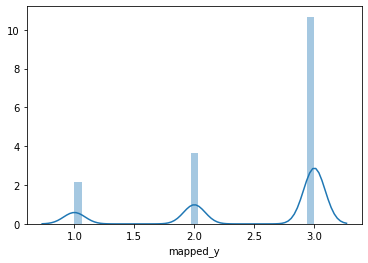

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.distplot(ytr)

plt.show()

############# подготовка #############

In [32]:
ytr[:10]

66734     3
62376     3
78493     1
89276     1
73820     3
48015     3
41700     3
134363    3
109962    3
96023     3
Name: mapped_y, dtype: int64

In [33]:
from sklearn import utils
ytr1 = ytr.astype('int')
yval1 = yval.astype('int')
utils.multiclass.type_of_target(ytr1)

'multiclass'

In [34]:
ytr1[:10]

66734     3
62376     3
78493     1
89276     1
73820     3
48015     3
41700     3
134363    3
109962    3
96023     3
Name: mapped_y, dtype: int32

############# CatBoostRegressor #############

In [35]:
from catboost import CatBoostRegressor

regr = CatBoostRegressor()

In [46]:
regr.fit(Xtr, ytr1)

Learning rate set to 0.072685
0:	learn: 0.7100267	total: 58ms	remaining: 58s
1:	learn: 0.7041135	total: 105ms	remaining: 52.6s
2:	learn: 0.6992092	total: 155ms	remaining: 51.5s
3:	learn: 0.6946441	total: 217ms	remaining: 53.9s
4:	learn: 0.6906470	total: 276ms	remaining: 55s
5:	learn: 0.6867728	total: 334ms	remaining: 55.4s
6:	learn: 0.6830200	total: 391ms	remaining: 55.4s
7:	learn: 0.6798312	total: 448ms	remaining: 55.6s
8:	learn: 0.6769055	total: 498ms	remaining: 54.9s
9:	learn: 0.6740303	total: 551ms	remaining: 54.5s
10:	learn: 0.6714782	total: 604ms	remaining: 54.3s
11:	learn: 0.6689935	total: 657ms	remaining: 54.1s
12:	learn: 0.6667344	total: 734ms	remaining: 55.7s
13:	learn: 0.6644196	total: 806ms	remaining: 56.7s
14:	learn: 0.6623539	total: 865ms	remaining: 56.8s
15:	learn: 0.6605174	total: 931ms	remaining: 57.2s
16:	learn: 0.6585618	total: 988ms	remaining: 57.1s
17:	learn: 0.6568147	total: 1.05s	remaining: 57.3s
18:	learn: 0.6550768	total: 1.11s	remaining: 57.4s
19:	learn: 0.653

162:	learn: 0.5868897	total: 8.57s	remaining: 44s
163:	learn: 0.5865953	total: 8.62s	remaining: 44s
164:	learn: 0.5862725	total: 8.68s	remaining: 43.9s
165:	learn: 0.5860315	total: 8.73s	remaining: 43.9s
166:	learn: 0.5857447	total: 8.78s	remaining: 43.8s
167:	learn: 0.5854138	total: 8.84s	remaining: 43.8s
168:	learn: 0.5850734	total: 8.9s	remaining: 43.8s
169:	learn: 0.5847898	total: 8.95s	remaining: 43.7s
170:	learn: 0.5844560	total: 9.02s	remaining: 43.7s
171:	learn: 0.5841294	total: 9.07s	remaining: 43.7s
172:	learn: 0.5837683	total: 9.12s	remaining: 43.6s
173:	learn: 0.5834916	total: 9.17s	remaining: 43.5s
174:	learn: 0.5832306	total: 9.21s	remaining: 43.4s
175:	learn: 0.5828714	total: 9.26s	remaining: 43.3s
176:	learn: 0.5825954	total: 9.3s	remaining: 43.3s
177:	learn: 0.5823091	total: 9.35s	remaining: 43.2s
178:	learn: 0.5819715	total: 9.39s	remaining: 43.1s
179:	learn: 0.5817519	total: 9.44s	remaining: 43s
180:	learn: 0.5815101	total: 9.48s	remaining: 42.9s
181:	learn: 0.581274

321:	learn: 0.5457498	total: 16.4s	remaining: 34.5s
322:	learn: 0.5455440	total: 16.4s	remaining: 34.4s
323:	learn: 0.5453584	total: 16.5s	remaining: 34.3s
324:	learn: 0.5451544	total: 16.5s	remaining: 34.3s
325:	learn: 0.5448944	total: 16.6s	remaining: 34.2s
326:	learn: 0.5446519	total: 16.6s	remaining: 34.2s
327:	learn: 0.5443917	total: 16.6s	remaining: 34.1s
328:	learn: 0.5441816	total: 16.7s	remaining: 34s
329:	learn: 0.5439391	total: 16.7s	remaining: 34s
330:	learn: 0.5437352	total: 16.8s	remaining: 33.9s
331:	learn: 0.5435323	total: 16.8s	remaining: 33.9s
332:	learn: 0.5432826	total: 16.9s	remaining: 33.8s
333:	learn: 0.5430362	total: 16.9s	remaining: 33.8s
334:	learn: 0.5427974	total: 17s	remaining: 33.7s
335:	learn: 0.5425866	total: 17s	remaining: 33.6s
336:	learn: 0.5423484	total: 17.1s	remaining: 33.6s
337:	learn: 0.5420989	total: 17.1s	remaining: 33.5s
338:	learn: 0.5418652	total: 17.2s	remaining: 33.5s
339:	learn: 0.5416425	total: 17.2s	remaining: 33.4s
340:	learn: 0.541455

482:	learn: 0.5130540	total: 24.3s	remaining: 26s
483:	learn: 0.5128395	total: 24.3s	remaining: 25.9s
484:	learn: 0.5126517	total: 24.4s	remaining: 25.9s
485:	learn: 0.5124540	total: 24.4s	remaining: 25.8s
486:	learn: 0.5122597	total: 24.5s	remaining: 25.8s
487:	learn: 0.5120785	total: 24.5s	remaining: 25.7s
488:	learn: 0.5119178	total: 24.5s	remaining: 25.7s
489:	learn: 0.5117602	total: 24.6s	remaining: 25.6s
490:	learn: 0.5115765	total: 24.6s	remaining: 25.5s
491:	learn: 0.5114202	total: 24.7s	remaining: 25.5s
492:	learn: 0.5112612	total: 24.7s	remaining: 25.4s
493:	learn: 0.5110511	total: 24.8s	remaining: 25.4s
494:	learn: 0.5108558	total: 24.8s	remaining: 25.3s
495:	learn: 0.5106967	total: 24.9s	remaining: 25.3s
496:	learn: 0.5104975	total: 24.9s	remaining: 25.2s
497:	learn: 0.5102705	total: 25s	remaining: 25.2s
498:	learn: 0.5101052	total: 25s	remaining: 25.1s
499:	learn: 0.5099652	total: 25.1s	remaining: 25.1s
500:	learn: 0.5098006	total: 25.1s	remaining: 25s
501:	learn: 0.509625

645:	learn: 0.4844501	total: 32.3s	remaining: 17.7s
646:	learn: 0.4842756	total: 32.3s	remaining: 17.6s
647:	learn: 0.4840830	total: 32.4s	remaining: 17.6s
648:	learn: 0.4839054	total: 32.4s	remaining: 17.5s
649:	learn: 0.4837612	total: 32.5s	remaining: 17.5s
650:	learn: 0.4835558	total: 32.5s	remaining: 17.4s
651:	learn: 0.4834173	total: 32.6s	remaining: 17.4s
652:	learn: 0.4831914	total: 32.6s	remaining: 17.3s
653:	learn: 0.4830385	total: 32.7s	remaining: 17.3s
654:	learn: 0.4829150	total: 32.7s	remaining: 17.2s
655:	learn: 0.4827590	total: 32.8s	remaining: 17.2s
656:	learn: 0.4825644	total: 32.8s	remaining: 17.1s
657:	learn: 0.4824027	total: 32.9s	remaining: 17.1s
658:	learn: 0.4822268	total: 32.9s	remaining: 17s
659:	learn: 0.4820934	total: 33s	remaining: 17s
660:	learn: 0.4819251	total: 33s	remaining: 16.9s
661:	learn: 0.4817717	total: 33.1s	remaining: 16.9s
662:	learn: 0.4816003	total: 33.1s	remaining: 16.8s
663:	learn: 0.4814191	total: 33.2s	remaining: 16.8s
664:	learn: 0.481288

805:	learn: 0.4592850	total: 40.2s	remaining: 9.68s
806:	learn: 0.4591149	total: 40.3s	remaining: 9.63s
807:	learn: 0.4590148	total: 40.3s	remaining: 9.58s
808:	learn: 0.4588778	total: 40.3s	remaining: 9.53s
809:	learn: 0.4587122	total: 40.4s	remaining: 9.47s
810:	learn: 0.4585550	total: 40.5s	remaining: 9.43s
811:	learn: 0.4584411	total: 40.5s	remaining: 9.38s
812:	learn: 0.4583005	total: 40.6s	remaining: 9.33s
813:	learn: 0.4581423	total: 40.6s	remaining: 9.28s
814:	learn: 0.4580322	total: 40.7s	remaining: 9.23s
815:	learn: 0.4578982	total: 40.7s	remaining: 9.18s
816:	learn: 0.4577732	total: 40.8s	remaining: 9.13s
817:	learn: 0.4576915	total: 40.8s	remaining: 9.08s
818:	learn: 0.4575060	total: 40.9s	remaining: 9.03s
819:	learn: 0.4573804	total: 40.9s	remaining: 8.98s
820:	learn: 0.4572427	total: 41s	remaining: 8.94s
821:	learn: 0.4571334	total: 41s	remaining: 8.89s
822:	learn: 0.4569730	total: 41.1s	remaining: 8.84s
823:	learn: 0.4568227	total: 41.2s	remaining: 8.79s
824:	learn: 0.45

964:	learn: 0.4370205	total: 48.1s	remaining: 1.75s
965:	learn: 0.4368937	total: 48.2s	remaining: 1.7s
966:	learn: 0.4367615	total: 48.2s	remaining: 1.65s
967:	learn: 0.4365942	total: 48.3s	remaining: 1.6s
968:	learn: 0.4364520	total: 48.4s	remaining: 1.55s
969:	learn: 0.4363339	total: 48.4s	remaining: 1.5s
970:	learn: 0.4362268	total: 48.5s	remaining: 1.45s
971:	learn: 0.4360806	total: 48.5s	remaining: 1.4s
972:	learn: 0.4359444	total: 48.6s	remaining: 1.35s
973:	learn: 0.4358080	total: 48.6s	remaining: 1.3s
974:	learn: 0.4356947	total: 48.7s	remaining: 1.25s
975:	learn: 0.4355853	total: 48.7s	remaining: 1.2s
976:	learn: 0.4354427	total: 48.8s	remaining: 1.15s
977:	learn: 0.4353133	total: 48.8s	remaining: 1.1s
978:	learn: 0.4352080	total: 48.9s	remaining: 1.05s
979:	learn: 0.4350739	total: 48.9s	remaining: 999ms
980:	learn: 0.4349478	total: 49s	remaining: 949ms
981:	learn: 0.4347967	total: 49s	remaining: 899ms
982:	learn: 0.4346516	total: 49.1s	remaining: 849ms
983:	learn: 0.4344984	t

In [47]:
regr.score(Xval, yval1)

0.30990861341052467

In [48]:
y_pred_val = regr.predict(Xval)

In [49]:
df = pd.DataFrame(list(zip(y_pred_val, yval)),
                                 columns = ['y_pred_val', 'yval'])
df.head(30)

,y_pred_val,yval
0,2.730713,3
1,2.864223,2
2,2.564891,2
3,2.721360,2
4,2.868415,3
5,1.956565,2
6,2.627838,3
7,2.510540,3
8,2.987410,3
9,2.365055,3


############# CatBoostClassifier #############

In [39]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier()

In [40]:
clf.fit(Xtr, ytr1)

Learning rate set to 0.094557
0:	learn: 1.0498712	total: 146ms	remaining: 2m 25s
1:	learn: 1.0122029	total: 271ms	remaining: 2m 15s
2:	learn: 0.9799984	total: 399ms	remaining: 2m 12s
3:	learn: 0.9558098	total: 528ms	remaining: 2m 11s
4:	learn: 0.9349879	total: 650ms	remaining: 2m 9s
5:	learn: 0.9156456	total: 787ms	remaining: 2m 10s
6:	learn: 0.9000981	total: 917ms	remaining: 2m 10s
7:	learn: 0.8871473	total: 1.07s	remaining: 2m 12s
8:	learn: 0.8745629	total: 1.22s	remaining: 2m 14s
9:	learn: 0.8640148	total: 1.36s	remaining: 2m 14s
10:	learn: 0.8553190	total: 1.5s	remaining: 2m 15s
11:	learn: 0.8469347	total: 1.65s	remaining: 2m 16s
12:	learn: 0.8399572	total: 1.79s	remaining: 2m 16s
13:	learn: 0.8343264	total: 1.94s	remaining: 2m 16s
14:	learn: 0.8285535	total: 2.08s	remaining: 2m 16s
15:	learn: 0.8227927	total: 2.23s	remaining: 2m 17s
16:	learn: 0.8179615	total: 2.38s	remaining: 2m 17s
17:	learn: 0.8136783	total: 2.52s	remaining: 2m 17s
18:	learn: 0.8097748	total: 2.64s	remaining: 2

159:	learn: 0.6809244	total: 20.6s	remaining: 1m 48s
160:	learn: 0.6804690	total: 20.8s	remaining: 1m 48s
161:	learn: 0.6799181	total: 20.9s	remaining: 1m 48s
162:	learn: 0.6793674	total: 21.1s	remaining: 1m 48s
163:	learn: 0.6787960	total: 21.2s	remaining: 1m 48s
164:	learn: 0.6783464	total: 21.3s	remaining: 1m 47s
165:	learn: 0.6778127	total: 21.5s	remaining: 1m 47s
166:	learn: 0.6772825	total: 21.6s	remaining: 1m 47s
167:	learn: 0.6768171	total: 21.7s	remaining: 1m 47s
168:	learn: 0.6762693	total: 21.9s	remaining: 1m 47s
169:	learn: 0.6756351	total: 22s	remaining: 1m 47s
170:	learn: 0.6750978	total: 22.1s	remaining: 1m 47s
171:	learn: 0.6745962	total: 22.3s	remaining: 1m 47s
172:	learn: 0.6740496	total: 22.5s	remaining: 1m 47s
173:	learn: 0.6734487	total: 22.6s	remaining: 1m 47s
174:	learn: 0.6730034	total: 22.7s	remaining: 1m 47s
175:	learn: 0.6725548	total: 22.8s	remaining: 1m 46s
176:	learn: 0.6721073	total: 23s	remaining: 1m 46s
177:	learn: 0.6716355	total: 23.1s	remaining: 1m 4

315:	learn: 0.6132405	total: 40.1s	remaining: 1m 26s
316:	learn: 0.6127895	total: 40.3s	remaining: 1m 26s
317:	learn: 0.6123722	total: 40.4s	remaining: 1m 26s
318:	learn: 0.6118867	total: 40.5s	remaining: 1m 26s
319:	learn: 0.6114376	total: 40.6s	remaining: 1m 26s
320:	learn: 0.6110067	total: 40.7s	remaining: 1m 26s
321:	learn: 0.6106977	total: 40.9s	remaining: 1m 26s
322:	learn: 0.6103186	total: 41s	remaining: 1m 25s
323:	learn: 0.6099384	total: 41.2s	remaining: 1m 25s
324:	learn: 0.6094074	total: 41.3s	remaining: 1m 25s
325:	learn: 0.6088325	total: 41.5s	remaining: 1m 25s
326:	learn: 0.6084095	total: 41.6s	remaining: 1m 25s
327:	learn: 0.6079753	total: 41.8s	remaining: 1m 25s
328:	learn: 0.6075762	total: 41.9s	remaining: 1m 25s
329:	learn: 0.6071210	total: 42.1s	remaining: 1m 25s
330:	learn: 0.6068198	total: 42.2s	remaining: 1m 25s
331:	learn: 0.6064188	total: 42.3s	remaining: 1m 25s
332:	learn: 0.6060451	total: 42.5s	remaining: 1m 25s
333:	learn: 0.6056398	total: 42.6s	remaining: 1m

471:	learn: 0.5574500	total: 59.8s	remaining: 1m 6s
472:	learn: 0.5570358	total: 59.9s	remaining: 1m 6s
473:	learn: 0.5566904	total: 1m	remaining: 1m 6s
474:	learn: 0.5564487	total: 1m	remaining: 1m 6s
475:	learn: 0.5561459	total: 1m	remaining: 1m 6s
476:	learn: 0.5558366	total: 1m	remaining: 1m 6s
477:	learn: 0.5555204	total: 1m	remaining: 1m 6s
478:	learn: 0.5551141	total: 1m	remaining: 1m 5s
479:	learn: 0.5547996	total: 1m	remaining: 1m 5s
480:	learn: 0.5545179	total: 1m	remaining: 1m 5s
481:	learn: 0.5541904	total: 1m 1s	remaining: 1m 5s
482:	learn: 0.5539808	total: 1m 1s	remaining: 1m 5s
483:	learn: 0.5536433	total: 1m 1s	remaining: 1m 5s
484:	learn: 0.5533959	total: 1m 1s	remaining: 1m 5s
485:	learn: 0.5531730	total: 1m 1s	remaining: 1m 5s
486:	learn: 0.5529463	total: 1m 1s	remaining: 1m 5s
487:	learn: 0.5526275	total: 1m 1s	remaining: 1m 5s
488:	learn: 0.5523037	total: 1m 2s	remaining: 1m 4s
489:	learn: 0.5519449	total: 1m 2s	remaining: 1m 4s
490:	learn: 0.5515551	total: 1m 2s	r

629:	learn: 0.5101092	total: 1m 19s	remaining: 46.8s
630:	learn: 0.5097683	total: 1m 19s	remaining: 46.7s
631:	learn: 0.5094451	total: 1m 19s	remaining: 46.6s
632:	learn: 0.5090798	total: 1m 20s	remaining: 46.4s
633:	learn: 0.5087963	total: 1m 20s	remaining: 46.3s
634:	learn: 0.5084922	total: 1m 20s	remaining: 46.2s
635:	learn: 0.5082277	total: 1m 20s	remaining: 46s
636:	learn: 0.5079608	total: 1m 20s	remaining: 45.9s
637:	learn: 0.5077171	total: 1m 20s	remaining: 45.8s
638:	learn: 0.5073786	total: 1m 20s	remaining: 45.7s
639:	learn: 0.5071445	total: 1m 20s	remaining: 45.5s
640:	learn: 0.5069235	total: 1m 21s	remaining: 45.4s
641:	learn: 0.5066317	total: 1m 21s	remaining: 45.3s
642:	learn: 0.5062948	total: 1m 21s	remaining: 45.2s
643:	learn: 0.5059977	total: 1m 21s	remaining: 45.1s
644:	learn: 0.5057081	total: 1m 21s	remaining: 44.9s
645:	learn: 0.5054688	total: 1m 21s	remaining: 44.8s
646:	learn: 0.5051660	total: 1m 21s	remaining: 44.7s
647:	learn: 0.5048474	total: 1m 22s	remaining: 4

785:	learn: 0.4665910	total: 1m 39s	remaining: 27s
786:	learn: 0.4663534	total: 1m 39s	remaining: 26.8s
787:	learn: 0.4659592	total: 1m 39s	remaining: 26.7s
788:	learn: 0.4656859	total: 1m 39s	remaining: 26.6s
789:	learn: 0.4653865	total: 1m 39s	remaining: 26.5s
790:	learn: 0.4651386	total: 1m 39s	remaining: 26.3s
791:	learn: 0.4648478	total: 1m 39s	remaining: 26.2s
792:	learn: 0.4645616	total: 1m 39s	remaining: 26.1s
793:	learn: 0.4642286	total: 1m 39s	remaining: 25.9s
794:	learn: 0.4640525	total: 1m 40s	remaining: 25.8s
795:	learn: 0.4638244	total: 1m 40s	remaining: 25.7s
796:	learn: 0.4635772	total: 1m 40s	remaining: 25.6s
797:	learn: 0.4633026	total: 1m 40s	remaining: 25.4s
798:	learn: 0.4630308	total: 1m 40s	remaining: 25.3s
799:	learn: 0.4627281	total: 1m 40s	remaining: 25.2s
800:	learn: 0.4624774	total: 1m 40s	remaining: 25.1s
801:	learn: 0.4621632	total: 1m 41s	remaining: 24.9s
802:	learn: 0.4619382	total: 1m 41s	remaining: 24.8s
803:	learn: 0.4616563	total: 1m 41s	remaining: 2

941:	learn: 0.4266659	total: 1m 58s	remaining: 7.29s
942:	learn: 0.4263705	total: 1m 58s	remaining: 7.17s
943:	learn: 0.4260586	total: 1m 58s	remaining: 7.04s
944:	learn: 0.4258274	total: 1m 58s	remaining: 6.92s
945:	learn: 0.4256109	total: 1m 58s	remaining: 6.79s
946:	learn: 0.4253217	total: 1m 59s	remaining: 6.66s
947:	learn: 0.4251329	total: 1m 59s	remaining: 6.54s
948:	learn: 0.4248939	total: 1m 59s	remaining: 6.41s
949:	learn: 0.4247240	total: 1m 59s	remaining: 6.29s
950:	learn: 0.4245089	total: 1m 59s	remaining: 6.16s
951:	learn: 0.4242433	total: 1m 59s	remaining: 6.03s
952:	learn: 0.4240098	total: 1m 59s	remaining: 5.91s
953:	learn: 0.4236924	total: 1m 59s	remaining: 5.78s
954:	learn: 0.4234306	total: 2m	remaining: 5.66s
955:	learn: 0.4232028	total: 2m	remaining: 5.53s
956:	learn: 0.4229420	total: 2m	remaining: 5.41s
957:	learn: 0.4227771	total: 2m	remaining: 5.28s
958:	learn: 0.4225217	total: 2m	remaining: 5.15s
959:	learn: 0.4223438	total: 2m	remaining: 5.03s
960:	learn: 0.422

In [41]:
clf.score(Xval, yval1)

0.696068143941732

In [42]:
y_pred_val = clf.predict(Xval)

In [44]:
df2 = pd.DataFrame(list(zip(y_pred_val, yval)),
                                 columns = ['y_pred_val', 'yval'])
df2.head(30)

,y_pred_val,yval
0,[3],3
1,[3],2
2,[3],2
3,[3],2
4,[3],3
5,[2],2
6,[3],3
7,[3],3
8,[3],3
9,[2],3
